# Data Reconciliation Economizer, Single Unit Example

This notebook demonstrates data reconciliation with a single unit model, an economizer.  Data for this example was generated by adding noise to supercritical power plant simulations.

### Why reconcile data?

Data reconciliation uses mass and energy balances along with redundant measurements to improve data quality by:

1. reducing measurement error,
2. ensuring measurements satisfy mass and energy balances, and
3. filling in unmeasured quantities.

Data reconciliation is used to refine process data before parameter estimation.

## 1.  Read Plant Data

The first step is to read in process data.  In this case, data was simulated by adding measurement error to supercritical steam cycle simulation results.  IDAES includes functions to read process data, convert units to match the models, and map data to the model.

In [1]:
# IDAES module with functions to read, analyze and visualize plant data
import idaes.dmf.model_data as da

Process data is contained in two csv files, a data file and a metadata file.  The data file where the first column is row indexes and the first row is process measurement tags.  The index column has an entry for each data row, and is often a timestamp.  The metadata file contains information about the tags including units of measurement, description, and model mapping information.

Once the process data is read in, the data is assigned to bins based on the value in a given column, in this case gross power. Dividing the data into bins allows rough estimation of measurement uncertainty.

In [2]:
# Read in data and column metadata
df, df_meta = da.read_data("plant_data.csv", "plant_data_meta.csv")
# Add bin information where the data is sorted into 5 MW bins based on the "GROSS_POWER" column
bin_count = da.bin_data(df, bin_by="POWER_GROSS", bin_no="bin_no", bin_nom="bin_power", bin_size=5e6)
# Calculate the standard deviation by bin for each column
bin_stdev = da.bin_stdev(df, bin_no="bin_no")

It can be useful to visualize the measurement data and estimated uncertainty.  The following creates box and whisker plots for each tag based on the data bins.

In [3]:
# Create a pdf book of plots that shows box and whisker plots for each column by bin
da.data_plot_book(df, bin_nom="bin_power", xlabel="gross power (W)", metadata=df_meta)
# There should now be a data_plot_book.pdf file in this directory

## 2.  Create Unit model

Now that we have the plant data, we need to create a unit model that we can use for data reconciliation.  Although we need a model that has just mass and energy balances and feasibility constraints for the data reconciliation problem, we start with the full economizer model here.  Using the same model for data reconciliation, parameter estimation, validation, and simulation reduces the work required to move between steps in the workflow.

Once the full model is created, constraints that are not needed for data reconciliation can be deactivated.

In [4]:
# Import models
from idaes.core import FlowsheetBlock
from idaes.power_generation.properties.IdealProp_FlueGas import FlueGasParameterBlock
from idaes.generic_models.properties import iapws95
from idaes.power_generation.unit_models.boiler_heat_exchanger import (
    BoilerHeatExchanger, 
    TubeArrangement, 
    DeltaTMethod
)
import pyomo.environ as pyo

In [5]:
# Create flowsheet with economizer
m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.prop_water = iapws95.Iapws95ParameterBlock()
m.fs.prop_fluegas = FlueGasParameterBlock()

m.fs.econ = BoilerHeatExchanger(default={
        "side_1_property_package": m.fs.prop_water,
        "side_2_property_package": m.fs.prop_fluegas,
        "has_pressure_change": True,
        "has_holdup": False,
        "delta_T_method": DeltaTMethod.counterCurrent,
        "tube_arrangement": TubeArrangement.inLine,
        "side_1_water_phase": "Liq",
        "has_radiation": False
    }
)

In [6]:
# Setup and initialize the model

# The steam properties use enthalpy as a state variable, so use temperature 
# and pressure to calculate a feedwater inlet enthalpy
h = iapws95.htpx(563.706, 2.5449e7)

m.fs.econ.side_1_inlet.flow_mol[0].fix(24678.26) # mol/s
m.fs.econ.side_1_inlet.enth_mol[0].fix(h) #J/mol         
m.fs.econ.side_1_inlet.pressure[0].fix(2.5449e7) # Pa

# Set the flue gas flow and composition
fg_rate = 28.3876e3  # mol/s equivalent of ~1930.08 klb/hr
fg_comp = { # mol fraction of flue gas components
    "H2O":8.69/100,
    "CO2":14.49/100,
    "O2":2.47/100,
    "NO":0.0006,
    "SO2":0.002,
}
# The rest is N2
fg_comp["N2"] = 1 - sum(fg_comp[i] for i in fg_comp)

# Set economizer inlets
for c in fg_comp:
    m.fs.econ.side_2_inlet.flow_component[0, c].fix(fg_rate*fg_comp[c])    
m.fs.econ.side_2_inlet.temperature[0].fix(682.335)  # K
m.fs.econ.side_2_inlet.pressure[0].fix(100145)  # Pa

# Set economizer design variables and parameters
ITM = 0.0254  # inch to meter conversion
# Based on NETL Baseline Report Rev4
m.fs.econ.tube_thickness.fix(0.188*ITM)  # tube thickness
m.fs.econ.tube_di.fix((2.0 - 2.0 * 0.188)*ITM) # calc inner diameter
m.fs.econ.pitch_x.fix(3.5*ITM)
m.fs.econ.pitch_y.fix(5.03*ITM)
m.fs.econ.tube_length.fix(53.41*12*ITM)  # use tube length (53.41 ft)
m.fs.econ.tube_nrow.fix(36*2.5) # use to match baseline performance
m.fs.econ.tube_ncol.fix(130) # 130 from thermoflow
m.fs.econ.nrow_inlet.fix(2)
m.fs.econ.delta_elevation.fix(50)
m.fs.econ.tube_r_fouling = 0.000176
m.fs.econ.shell_r_fouling = 0.00088
m.fs.econ.fcorrection_htc.fix(1.5)
m.fs.econ.fcorrection_dp_tube.fix(1.0)
m.fs.econ.fcorrection_dp_shell.fix(1.0)

In [7]:
# Initialize economizer
m.fs.econ.initialize(
    state_args_1={
        "flow_mol": m.fs.econ.side_1_inlet.flow_mol[0].value,
        "pressure": m.fs.econ.side_1_inlet.pressure[0].value,
        "enth_mol": m.fs.econ.side_1_inlet.enth_mol[0].value,
    },
    state_args_2={
        "flow_component":{
            "H2O": m.fs.econ.side_2_inlet.flow_component[0, "H2O"].value,
            "CO2": m.fs.econ.side_2_inlet.flow_component[0, "CO2"].value,
            "N2": m.fs.econ.side_2_inlet.flow_component[0, "N2"].value,
            "O2": m.fs.econ.side_2_inlet.flow_component[0, "O2"].value,
            "NO": m.fs.econ.side_2_inlet.flow_component[0, "NO"].value,
            "SO2": m.fs.econ.side_2_inlet.flow_component[0, "SO2"].value,
        },
        "temperature": m.fs.econ.side_2_inlet.temperature[0].value,
        "pressure": m.fs.econ.side_2_inlet.pressure[0].value,
    }
)

2020-06-19 10:43:02 [INFO] idaes.init.fs.econ.side_1: Initialization Complete
2020-06-19 10:43:02 [INFO] idaes.init.fs.econ.side_2: Initialization Complete


## 3.  Simplify to Mass and Energy Balances

For data reconciliation, the model should be reduced to mass and energy balances and potentially limited performance constraints to keep the results feasible.

In [8]:
# Deactivate constraints for heat transfer
m.fs.econ.overall_heat_transfer_coefficient_eqn.deactivate()
m.fs.econ.rcond_wall_eqn.deactivate()
m.fs.econ.hconv_shell_total_eqn.deactivate()
m.fs.econ.hconv_shell_conv_eqn.deactivate()
m.fs.econ.N_Nu_shell_eqn.deactivate()
m.fs.econ.N_Pr_shell_eqn.deactivate()
m.fs.econ.deltaP_shell_eqn.deactivate()
m.fs.econ.friction_factor_shell_eqn.deactivate()
m.fs.econ.N_Re_shell_eqn.deactivate()
m.fs.econ.v_shell_eqn.deactivate()
m.fs.econ.hconv_tube_eqn.deactivate()
m.fs.econ.N_Nu_tube_eqn.deactivate()
m.fs.econ.N_Pr_tube_eqn.deactivate()
m.fs.econ.deltaP_tube_eqn.deactivate()
m.fs.econ.deltaP_tube_uturn_eqn.deactivate()
m.fs.econ.deltaP_tube_friction_eqn.deactivate()
m.fs.econ.friction_factor_tube_eqn.deactivate()
m.fs.econ.N_Re_tube_eqn.deactivate()
m.fs.econ.v_tube_eqn.deactivate()
m.fs.econ.LMTD.deactivate()

## 4. Map Data to the Model

Although the model mapping can be added to the tag metadata file, here we just add the mapping information to the tag metadata after reading the data.

In [9]:
df_meta["ECON_OUT_F"]["reference_string"] = "m.fs.econ.side_1.properties_out[:].flow_mol"
df_meta["ECON_OUT_T"]["reference_string"] = "m.fs.econ.side_1.properties_out[:].temperature"
df_meta["ECON_OUT_P"]["reference_string"] = "m.fs.econ.side_1.properties_out[:].pressure"
df_meta["BFW_F"]["reference_string"] = "m.fs.econ.side_1.properties_in[:].flow_mol"
df_meta["BFW_T"]["reference_string"] = "m.fs.econ.side_1.properties_in[:].temperature"
df_meta["BFW_P"]["reference_string"] = "m.fs.econ.side_1.properties_in[:].pressure"
df_meta["FG_2_ECON_Fm"]["reference_string"] = "m.fs.econ.side_2.properties_in[:].flow_mass"
df_meta["FG_2_ECON_T"]["reference_string"] = "m.fs.econ.side_2.properties_in[:].temperature"
df_meta["FG_2_ECON_P"]["reference_string"] = "m.fs.econ.side_2.properties_in[:].pressure"
df_meta["FG_2_AIRPH_Fm"]["reference_string"] = "m.fs.econ.side_2.properties_out[:].flow_mass"
df_meta["FG_2_AIRPH_T"]["reference_string"] = "m.fs.econ.side_2.properties_out[:].temperature"
df_meta["FG_2_AIRPH_P"]["reference_string"] = "m.fs.econ.side_2.properties_out[:].pressure"

In [10]:
# Add the model references to the tag metadata based on the strings above.
da.upadate_metadata_model_references(m, df_meta)

In [11]:
# Create a dictionary of data tags that we want to use for the data reconciliation problem.  
# The key is the tag and the value is a reference to a quantity in the model.  
data_tags = {k:v["reference"][0] for k, v in df_meta.items() if v["reference"] is not None}

In [12]:
# Now for result output, the data reconciliation usually can give full stream information for a flowsheet
# including quantities that are unmeasured.  To more easily use the results, it is good practice to map most of
# the data reconciliation results to flowsheet stream names.  
import idaes.core.util.tables as ta

stream_dict = ta.arcs_to_stream_dict(
    m, 
    additional={
        "S042": m.fs.econ.side_1_inlet,
        "B002": m.fs.econ.side_1_outlet,
        "G012": m.fs.econ.side_2_inlet,
        "G013": m.fs.econ.side_2_outlet,
    },
    sort=True,
)

state_dict = ta.stream_states_dict(stream_dict, time_point=0)
# The 'tag_state_quantities()' function below iterates through the state block
# dictionary and creates tags for the listed attributes by combining the state
# block label with the attribute label in the labels argument.  For example
# pressure in the S042 state block would get the tag 'S042_P'.
recon_tags = ta.tag_state_quantities(
    blocks=state_dict, 
    attributes=(
        "flow_mass", 
        "flow_mol", 
        "enth_mol", 
        "temperature", 
        "pressure", 
        ("flow_component", "O2"),
        ("flow_component", "NO"),
        ("flow_component", "N2"),
        ("flow_component", "SO2"),
        ("flow_component", "CO2"),
        ("flow_component", "H2O"),
    ), 
    labels=("_Fm", "_F", "_h", "_T", "_P", "_F[O2]", "_F[NO]", "_F[N2]", "_F[SO2]", "_F[CO2]", "_F[H2O]"),
)
recon_tags["ECON_Q"] = m.fs.econ.heat_duty[0]

## 5. View model flowsheet

Model results or other quantities can be added to a process flow diagram.  The PFD was drawn beforehand and the model results are added to tagged locations on the PFD.

In [13]:
from idaes.core.util.misc import svg_tag  # utility to place numbers/text in an SVG

with open("econ.svg", "r") as f:
    s = svg_tag(svg=f, tags={"subtitle":"Initialized Model"})
    s = svg_tag(svg=s, tags=recon_tags, outfile="econ_init.svg")

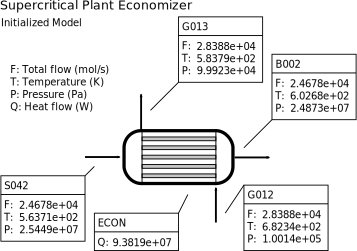

In [14]:
from IPython.display import SVG, display

display(SVG(s))

## 6.  Write Objective

Next we write the objective function and additional constraints for the data reconciliation problem.  The objective is

$$\min \sum_i \left(\frac{x_{\text{data}, i} - x_{\text{model}, i}}{\sigma_i} \right)^2$$

Where $i \in \{\text{Measured Quantities}\}$ and $\sigma_i$ is the standard deviation of measurement i estimated by binning the data.

In [15]:
# Add model parameters to contain measured data.  These are mutable so we can set a specific 
# change to specific data points later.
m.data = pyo.Param(data_tags, mutable=True, doc="Process data for a specific point in time.")
m.data_stdev = pyo.Param(data_tags, mutable=True, doc="Process data standard deviation.")

In [16]:
# The 'set_data' function below takes data from the model DataFrame and updates the
# model data parameters.
def set_data(m, df, data_tags, index=None, indexindex=None):
    if index is None:
        index = df.index[indexindex]
    m.bin_no = df.iloc[index]["bin_no"]
    for t in data_tags:
        m.data[t] = df.iloc[index][t]
        m.data_stdev[t] = bin_stdev[m.bin_no][t]

In [17]:
# So we have something reasonable to start, set the data attached to the model to the first 
# data point.
set_data(m, df, data_tags, indexindex=0)

Add an expression for error divided by the standard deviation, and use it to write the data reconciliation objective function.

In [18]:
@m.Expression(data_tags)
def err(m, i):
    return (m.data[i] - data_tags[i])/m.data_stdev[i]

m.objective = pyo.Objective(expr=sum(m.err[t]**2 for t in m.err))

Add constraints that ensure reasonable temperature and keep the flue gas composition correct.

In [19]:
# Limit temperature approach
m.c1 = pyo.Constraint(expr=m.fs.econ.deltaT_1[0] >= 1.0)
m.c2 = pyo.Constraint(expr=m.fs.econ.deltaT_2[0] >= 1.0)

# Constraint flue gas composition
m.flow_fg = pyo.Var(initialize=fg_rate)
@m.Constraint(fg_comp)
def eq_fg_comp(b, c):
    return m.fs.econ.side_2_inlet.flow_component[0, c] == fg_comp[c]*m.flow_fg

## 7. Solve Optimization

Now we need to solve the data reconciliation problem for every data point.  The important results are stored in two DataFrames ```df_result``` which contains results tagged based on model stream names to be used in the parameter estimation step and ```df_result_cmp``` which contains reconciled data based on the original measurement tags and can be used to compare the original measurements to the reconciled results.

In [20]:
m.fs.econ.side_1_inlet.unfix()
m.fs.econ.side_2_inlet.unfix()
m.fs.econ.side_1_outlet.unfix()
m.fs.econ.side_2_outlet.unfix()

In [21]:
solver = pyo.SolverFactory('ipopt')

In [22]:
import pandas as pd
# add bin information to reconciliation results so it can be used in parameter estimation
df_result = pd.DataFrame(columns=list(recon_tags.keys())+["termination", "bin_no", "bin_power"], index=df.index)
df_result_cmp = pd.DataFrame(columns=list(data_tags.keys())+["termination"], index=df.index)

for i in df.index:
    set_data(m, df, data_tags, index=i)
    res = solver.solve(m)
    tc = str(res.solver.termination_condition)
    df_result.iloc[i]["termination"] = tc
    df_result.iloc[i]["bin_no"] = df.iloc[i]["bin_no"]
    df_result.iloc[i]["bin_power"] = df.iloc[i]["bin_power"]
    df_result_cmp.iloc[i]["termination"] = tc
    for t in recon_tags:
        df_result.iloc[i][t] = pyo.value(recon_tags[t])
    for t in data_tags:
        df_result_cmp.iloc[i][t] = pyo.value(data_tags[t])
    # Show something so you can tell progress is happening
    print(f"{i} -- {tc}, objective: {pyo.value(m.objective)}")

0 -- optimal, objective: 6.3676472875232
1 -- optimal, objective: 2.208442659784933
2 -- optimal, objective: 3.94267720445207
3 -- optimal, objective: 8.049407307883618
4 -- optimal, objective: 0.42616943118761463
5 -- optimal, objective: 1.299319234380689
6 -- optimal, objective: 4.513372717756357
7 -- optimal, objective: 4.069601420418466
8 -- optimal, objective: 2.3053097172615846
9 -- optimal, objective: 3.312310414793322
10 -- optimal, objective: 1.502760726443518
11 -- optimal, objective: 0.7727525280213949
12 -- optimal, objective: 0.8626544533895271
13 -- optimal, objective: 2.4780376242443714
14 -- optimal, objective: 11.328606681334069
15 -- optimal, objective: 1.9605951552533885
16 -- optimal, objective: 0.1707649028786835
17 -- optimal, objective: 3.118275617993754
18 -- optimal, objective: 2.4549382324462266
19 -- optimal, objective: 0.7619302040715454
20 -- optimal, objective: 4.015109114703963
21 -- optimal, objective: 5.868895479165451
22 -- optimal, objective: 2.975868

183 -- optimal, objective: 3.041525713196924
184 -- optimal, objective: 2.193700389932764
185 -- optimal, objective: 5.048503689995228
186 -- optimal, objective: 2.000706799476936
187 -- optimal, objective: 0.8572260632183024
188 -- optimal, objective: 1.2022722904590035
189 -- optimal, objective: 4.659421601348486
190 -- optimal, objective: 2.280709797778068
191 -- optimal, objective: 1.8941062058163558
192 -- optimal, objective: 1.3575262627925613
193 -- optimal, objective: 2.7360842524158544
194 -- optimal, objective: 1.2026427648988114
195 -- optimal, objective: 1.3195547771155411
196 -- optimal, objective: 1.2913895289907817
197 -- optimal, objective: 5.3698371405781575
198 -- optimal, objective: 8.427219972434015
199 -- optimal, objective: 2.5489723751028452
200 -- optimal, objective: 2.5956264977758994
201 -- optimal, objective: 1.3887622710615177
202 -- optimal, objective: 0.04456507056190462
203 -- optimal, objective: 4.3615806896515315
204 -- optimal, objective: 0.75901008377

In [23]:
# Save the reconciled data to be used for parameter estimation
df_result.to_csv("econ_recon.csv")

In [24]:
# Create a new plot book to compare the original data to the reconciled data.
da.data_rec_plot_book(
    df_data=df, 
    df_rec=df_result_cmp,
    bin_nom="bin_power", 
    xlabel="gross power (W)", 
    metadata=df_meta
)